# 多层神经网络
首先用logistic解决一下线性分不是很好的模型，然后用多层神经网络尝试分割

In [26]:
import torch
import numpy as np
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from matplotlib  import pyplot as plt

In [27]:
#生成数据
np.random.seed(1)
m = 400 
N = int(m/2) 
D = 2 
x = np.zeros((m, D))
y = np.zeros((m, 1), dtype='uint8') #0或者1
a = 4

for j in range(2):
    ix = range(N*j,N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 
    x[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
x_data=x[:,0:2]
y_data=y[:,-1]

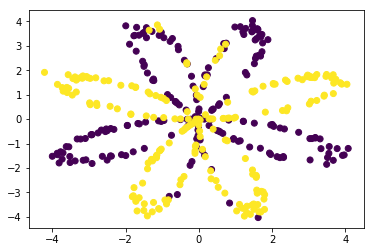

In [28]:
plt.scatter(x[:,0],x[:,1],c=y.reshape(-1))

In [29]:
#使用logistic解决
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression,self).__init__()
        self.lr=nn.Linear(2,1)#2个参数1个输出
        self.sm=nn.Sigmoid()
    def forward(self,x):
        x=self.lr(x)
        x=self.sm(x)
        return x
logistic_model=LogisticRegression()
criterion=nn.BCELoss()
optimizer=torch.optim.SGD(logistic_model.parameters(),lr=1e-3,momentum=0.9)#动量相当于避免局部最优
for epoch in range(50000):
    x=Variable(torch.from_numpy(x_data))
    y=Variable(torch.from_numpy(y_data).unsqueeze(1))
    out=logistic_model(x.float())
    loss=criterion(out,y.float())
    loss.backward()
    optimizer.step()
    if (epoch+1)%20000==0:
        print('times[{}/{}],loss:{}'.format(epoch+1,50000,loss.data[0]))

times[20000/50000],loss:9.080534935
times[40000/50000],loss:9.06007671356


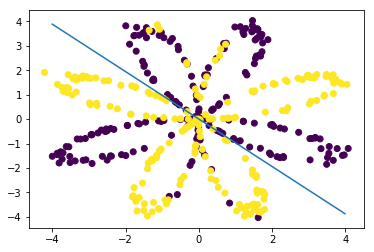

In [34]:
w0,w1=logistic_model.lr.weight[0]
w0=w0.data[0]
w1=w1.data[0]
b=logistic_model.lr.bias.data[0]
plot_x=np.arange(-4,4,0.01)
plot_y=(-w0*plot_x-b)/w1
plt.scatter(x[:,0],x[:,1],c=y_data.reshape(-1))
plt.plot(plot_x,plot_y)
plt.show()

logistic并不能很好的分开这个数据集，误差在8.0左右，所以这时使用一下多曾神经网络

In [38]:
w1=nn.Parameter(torch.randn(2,4)*0.01)
b1=nn.Parameter(torch.zeros(4))
w2=nn.Parameter(torch.randn(4,1)*0.01)
b2=nn.Parameter(torch.zeros(1))
def two_network(x):
    x1=torch.mm(x,w1)+b1
    x1=F.tanh(x1)
    x2=torch.mm(x1,w2)+b2#第二层
    return x2
optimizer=torch.optim.SGD([w1,b1,w2,b2],1.)
criterion=nn.BCEWithLogitsLoss()
for epoch in range(10000):
    out=two_network(x.float())
    loss=criterion(out,y.float())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%2000==0:
        print('times:{}/{},loss={}'.format(epoch,10000,loss.data[0]))

times:0/10000,loss=0.693104624748
times:2000/10000,loss=0.273554950953
times:4000/10000,loss=0.260536521673
times:6000/10000,loss=0.226550146937
times:8000/10000,loss=0.219885706902


loss明显小了很多啊，接下来在图中画出来

Text(0.5,1,'2 layer network')

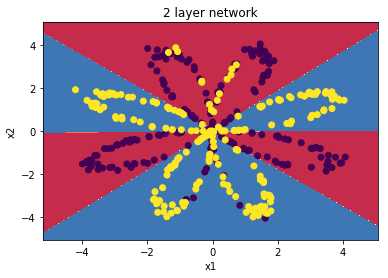

In [43]:
def plot_decision_boundary(model, x, y):
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(x[:, 0], x[:, 1], c=y.reshape(-1))
def plot_network(x):
    x=Variable(torch.from_numpy(x).float())
    x1=torch.mm(x,w1)+b1
    x1=F.tanh(x1)
    x2=torch.mm(x1,w2)+b2
    out=F.sigmoid(x2)
    out=(out>0.5)*1
    return out.data.numpy()

plot_decision_boundary(lambda x: plot_network(x), x_data, y_data)
plt.title('2 layer network')



# Summary
用了二层网络出现的结果非常好，只有部分不吻合，但是感觉再精确一点就过拟合了。准备去补一波matplotlib了，还是不熟练